# Setup

In [1]:
#import dependencies
import pandas as pd
import sys
import requests
import gmaps
import matplotlib.pyplot as plt
from pprint import pprint

#plot style
plt.style.use('dark_background')

#api-key in different folder, so need to adjust filepath
sys.path.append('/Users/Chrismus Time/Desktop/inca-digital-remittance-kyc-report')

#import api-key for google maps
from config import gkey

In [2]:
#import csv of countries
country_df = pd.read_csv('Resources/Country_Empty.csv')
country_df.head(5)

,Countries
0,Afghanistan
1,Chile
2,Croatia
3,Dominican Republic
4,El Salvador


# Fetching Geocoordinates of Countries

In [3]:
#GEO url setup
geo_params = {
    'address' : '', #empty, will populated in forloop below
    'key' : gkey
}
geo_url = 'https://maps.googleapis.com/maps/api/geocode/json'

In [4]:
#setting up lists for geo-requests
country_cd_ls, lat_ls, long_ls = [], [], [] #empty lists to geo-requests to populate data into
country_ls = country_df['Countries'].tolist() #list of countries to iterate through, for-loop below

In [5]:
#populating lists with relevant data
for i in range(len(country_ls)): #for every country...
    #add the relevant api parameters
    geo_params['address'] = country_ls[i]
    #fetching API data
    geo_response = requests.get(geo_url, params = geo_params).json()
    #indexing into geo_response to get info, then add to correct list
    country_cd_ls.append(geo_response['results'][0]['address_components'][0]['short_name'])
    lat_ls.append(geo_response['results'][0]['geometry']['location']['lat'])
    long_ls.append(geo_response['results'][0]['geometry']['location']['lng'])
    print(f"Processed {country_ls[i]} data, {i+1}/{len(country_ls)}")

Processed Afghanistan data, 1/17
Processed Chile data, 2/17
Processed Croatia data, 3/17
Processed Dominican Republic data, 4/17
Processed El Salvador data, 5/17
Processed Ecuador data, 6/17
Processed Iran data, 7/17
Processed Kazakhstan data, 8/17
Processed Morocco data, 9/17
Processed Pakistan data, 10/17
Processed Peru data, 11/17
Processed Philippines data, 12/17
Processed Saudi Arabia data, 13/17
Processed Switzerland data, 14/17
Processed Ukraine data, 15/17
Processed United Arab Emirates data, 16/17
Processed Vietnam data, 17/17


In [6]:
#adding data into country_df
country_df['Country Code'] = country_cd_ls
country_df['Latitude'] = lat_ls
country_df['Longitude'] = long_ls
country_df

,Countries,Country Code,Latitude,Longitude
0,Afghanistan,AF,33.939110,67.709953
1,Chile,CL,-35.675147,-71.542969
2,Croatia,HR,45.100000,15.200000
3,Dominican Republic,DO,18.735693,-70.162651
4,El Salvador,SV,13.794185,-88.896530
5,Ecuador,EC,-1.831239,-78.183406
6,Iran,IR,32.427908,53.688046
7,Kazakhstan,KZ,48.019573,66.923684
8,Morocco,MA,31.791702,-7.092620
9,Pakistan,PK,30.375321,69.345116


# Plotting Countries via Geocoordinates

In [7]:
#figure settings
fig_settings = {
    'width': '600px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

#create fig object
fig = gmaps.figure(layout = fig_settings)

In [8]:
#generating marker variables
coordinates = list(zip(country_df['Latitude'].tolist(), country_df['Longitude'].tolist()))

#create info box format
info_box_format = """
<dd><b>{Countries}</b>, {Country Code}</dd>
{Latitude}, {Longitude}
"""

#populating format for each city
country_names = [info_box_format.format(**row) for index, row in country_df.iterrows()]

#creating marker layer
marker_layer = gmaps.marker_layer(coordinates, info_box_content = country_names)

#adding markers to map
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', margin='0 auto 0 auto', padding='1px', wi…

# Fetching Worldbank Data

In [9]:
#WDB url setup
wdb_params = {
    'format' : 'json',
    'date' : '2010:2020',
    'gapfill' : 'Y', #if value is null, go back to previous years to fill in
    'mrv' : '7' #the max number of years to go back to gapfill
}

#creating empty lists for storage
pov_ls, remit_ls, cpi_ls, gdp_ls = [], [], [], []

In [10]:
for i in range(len(country_cd_ls)):
    #grabbing the country code for each code
    country_code = country_cd_ls[i]
    
    #creating custom urls for each country
    wdb_pov_url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/SI.POV.NAHC"
    wdb_remit_url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/BX.TRF.PWKR.DT.GD.ZS"
    wdb_cpi_url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/FP.CPI.TOTL"
    wdb_gdp_url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/NY.GDP.MKTP.CD"
    
    #api request using each custom url
    wdb_pov_response = requests.get(wdb_pov_url, params = wdb_params).json()
    wdb_remit_response = requests.get(wdb_remit_url, params = wdb_params).json()
    wdb_cpi_response = requests.get(wdb_cpi_url, params = wdb_params).json()
    wdb_gdp_response = requests.get(wdb_gdp_url, params = wdb_params).json()
    
    #indexing into wdb_response to get info, then add to correct list
    pov_ls.append(wdb_pov_response[1][1]['value']) # Poverty headcount ratio at national poverty lines (% of population)
    remit_ls.append(wdb_remit_response[1][1]['value']) # Personal remittances, received (% of GDP)
    cpi_ls.append(wdb_cpi_response[1][1]['value']) # Consumer price index
    gdp_ls.append(round(wdb_gdp_response[1][1]['value']/10000000,2)) # GDP (current US$)
    print(f"Processed {country_ls[i]} data, {i+1}/{len(country_ls)}")

Processed Afghanistan data, 1/17
Processed Chile data, 2/17
Processed Croatia data, 3/17
Processed Dominican Republic data, 4/17
Processed El Salvador data, 5/17
Processed Ecuador data, 6/17
Processed Iran data, 7/17
Processed Kazakhstan data, 8/17
Processed Morocco data, 9/17
Processed Pakistan data, 10/17
Processed Peru data, 11/17
Processed Philippines data, 12/17
Processed Saudi Arabia data, 13/17
Processed Switzerland data, 14/17
Processed Ukraine data, 15/17
Processed United Arab Emirates data, 16/17
Processed Vietnam data, 17/17


In [11]:
#adding data into country_df
country_df['Poverty Headcount (% of National)'] = pov_ls
country_df['Personal Remittances (% of GDP)'] = remit_ls
country_df['CPI'] = cpi_ls
country_df['GDP (in millions $USD)'] = gdp_ls
country_df

,Countries,Country Code,Latitude,Longitude,Poverty Headcount (% of National),Personal Remittances (% of GDP),CPI,GDP (in millions $USD)
0,Afghanistan,AF,33.939110,67.709953,54.5,4.295098,149.895975,1929.11
1,Chile,CL,-35.675147,-71.542969,8.6,0.024830,131.913567,27938.55
2,Croatia,HR,45.100000,15.200000,18.3,6.637706,109.815676,6075.26
3,Dominican Republic,DO,18.735693,-70.162651,21.0,8.343256,132.172235,8894.13
4,El Salvador,SV,13.794185,-88.896530,NaN,21.047819,111.228352,2689.67
5,Ecuador,EC,-1.831239,-78.183406,25.0,2.999486,124.142675,10810.80
6,Iran,IR,32.427908,53.688046,NaN,0.515014,550.929425,25824.55
7,Kazakhstan,KZ,48.019573,66.923684,4.3,0.278573,188.516434,18166.72
8,Morocco,MA,31.791702,-7.092620,4.8,5.816675,111.067558,11970.03
9,Pakistan,PK,30.375321,69.345116,21.9,7.997932,182.320933,27822.19


# Plotting Countries

In [12]:
# creating list for subplotting
plot_headers = ['Poverty Headcount (% of National)', 'Personal Remittances (% of GDP)', 'CPI', 'GDP (in millions $USD)']
plot_ylabels = ['% of Population', '% of GDP', 'Score', 'Millions of USD']
plot_titles = ['Poverty Headcount Ratio at National Poverty Lines (% of Population)', 'Personal Remittances Received (% of GDP)', 'Consumer Price Index (CPI)', 'Gross Domestic Product (GDP)']
colors_ls = ['red', 'blue', 'green', 'teal']

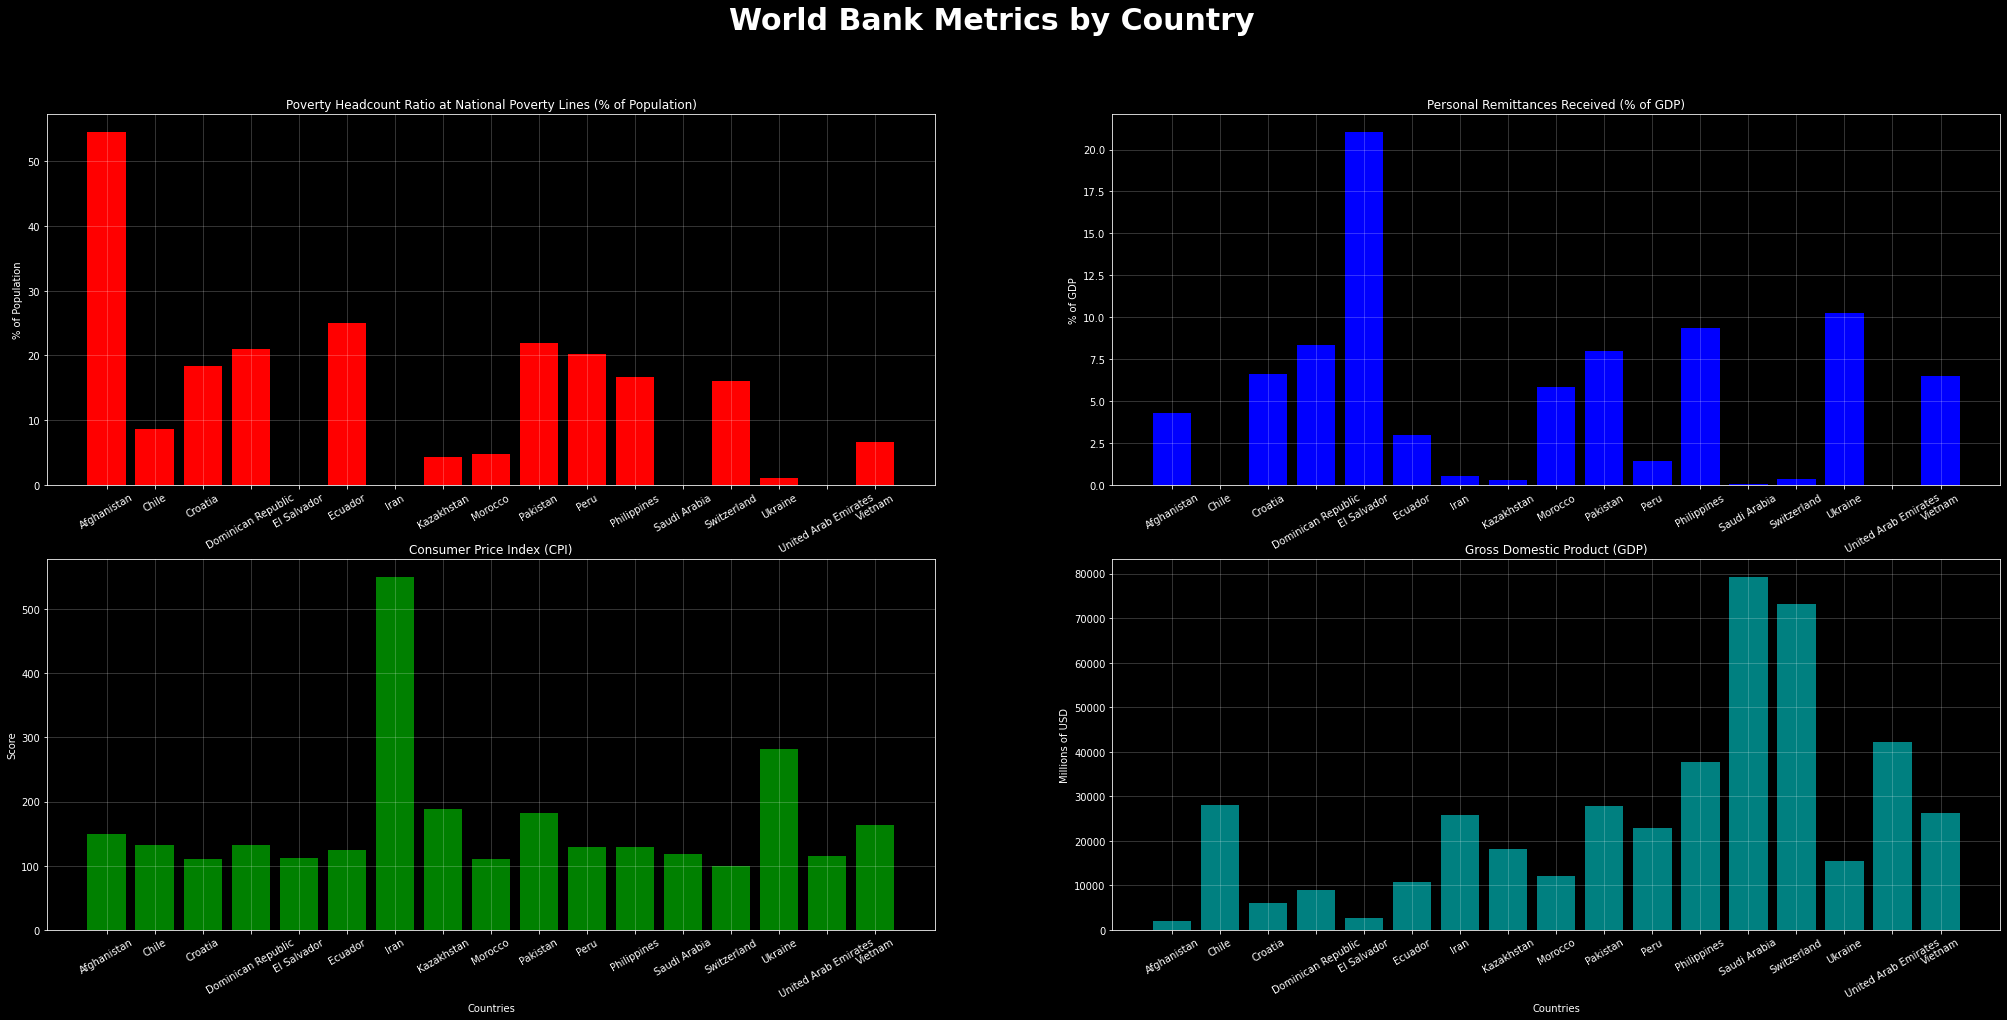

In [13]:
#scatterplot setup
fig, ((gr0, gr1), (gr2, gr3)) = plt.subplots(2, 2, figsize = (35,15))
fig.suptitle("World Bank Metrics by Country", fontsize = 30, fontweight = 'bold')

#plotting graph
for i in range(len(plot_headers)):
    #plot scatter
    eval(f"gr{i}").bar(country_df['Countries'], country_df[plot_headers[i]], color = colors_ls[i])
    #set grid background
    eval(f"gr{i}").grid(alpha = 0.25)
    #add ylabels
    plt.setp(eval(f"gr{i}").xaxis.get_majorticklabels(), rotation = 30)
    plt.setp(eval(f"gr{i}"), ylabel = plot_ylabels[i], xlabel = 'Countries', title = plot_titles[i])

#saving figure
plt.savefig("Images/prework_graph.png")

#saving dataframe
country_df.to_csv("Resources/Country_Filled.csv")